# Analyze Neurons

Analyze neurons to construct cell types using data from "Transcriptomic diversity of cell types across the adult human brain," published on bioRxiv, 2022 (DOI: [10.1101/2022.10.12.511898](https://doi.org/10.1101/2022.10.12.511898)). For more information, see also the [`scanpy` documentation](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

First, load relevant packages.

In [1]:
# standard imports
import numpy as np
import pandas as pd
import os
import time

# path manipulation
from pathlib import Path

# string manipulation
import re

# single cell analysis
import scanpy as sc
import anndata

# matplotlib imports
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

# import project config file
import sys
sys.path.append('../..')
import project_config

Note that directories are relative to the project path.

In [2]:
# set directories
neuroKG_dir = project_config.PROJECT_DIR / 'Data' / 'NeuroKG'
ensembl_dir = project_config.PROJECT_DIR / 'Data' / 'Ensembl'
snRNAseq_dir = project_config.PROJECT_DIR / 'Data' / 'CELLxGENE' / 'linnarsson'

# define output directory
output_dir = project_config.PROJECT_DIR / 'Data' / 'CELLxGENE' / 'linnarsson' / 'processed'

Read the `.h5ad` AnnData files containing the nervous and non-nervous data.

In [3]:
# read nervous data, takes 9 minutes to load
neurons = sc.read_h5ad(snRNAseq_dir / 'Neurons.h5ad')
neurons

AnnData object with n_obs × n_vars = 2480956 × 59480
    obs: 'BadCells', 'Paris10', 'Paris21', 'Paris9', 'PunchcardClusters', 'ROIGroup', 'ROIGroupCoarse', 'ROIGroupFine', 'Split', 'TopSplit', 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'cluster_id', 'subcluster_id', 'supercluster_term', 'cell_type_ontology_term_id', 'tissue_ontology_term_id'
    var: 'Biotype', 'Chromosome', 'End', 'Gene', 'Start'
    uns: 'batch_condition', 'schema_version', 'title'
    obsm: 'X_UMAP', 'X_tSNE'

Show the gene-level metadata.

In [4]:
# show gene level metadata
neurons.var.head()

,Biotype,Chromosome,End,Gene,Start
Accession,,,,,
Cas9,protein_coding,chrEXTRA,12412,transgen-Cas9,8081
EGFP,protein_coding,chrEXTRA,13152,marker-EGFP,12433
ENSG00000000003.15,n/a,chrX,100639991,TSPAN6,100627108
ENSG00000000005.6,n/a,chrX,100599885,TNMD,100584936
ENSG00000000419.13,n/a,chr20,50958555,DPM1,50934867


Perform quality checks.

In [5]:
# remove doublets
pre_bad_cells = neurons.n_obs
neurons = neurons[neurons.obs.BadCells != 1, :] # indicates doublets?
post_bad_cells = neurons.n_obs
print('Number of cells removed: {:d}'.format(pre_bad_cells - post_bad_cells))

# annotate mitochondrial genes
neurons.var['mt'] = neurons.var.Gene.str.startswith('MT-')

# perform quality control
sc.pp.calculate_qc_metrics(neurons, qc_vars = ['mt'], percent_top = None, log1p = True, inplace = True)

Number of cells removed: 52774


/tmp/ipykernel_49048/2952078737.py:8: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  neurons.var['mt'] = neurons.var.Gene.str.startswith('MT-')


Create violin plot of some of the computed quality measures:
* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

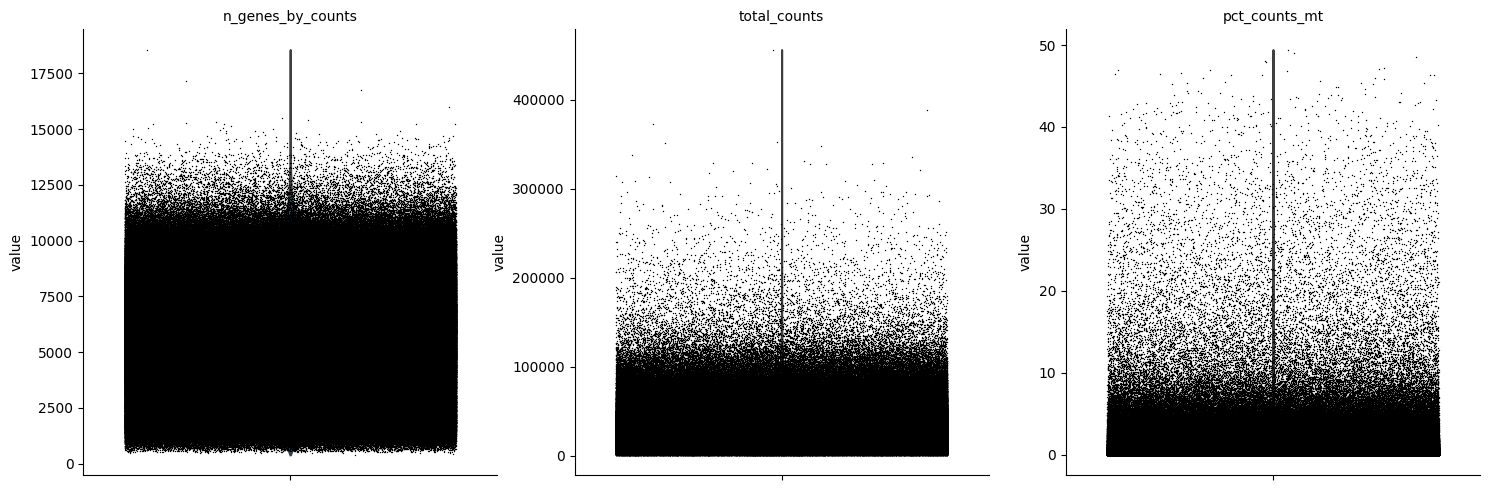

In [6]:
# create violin plot
sc.pl.violin(neurons, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

Visualize results in scatter plot.

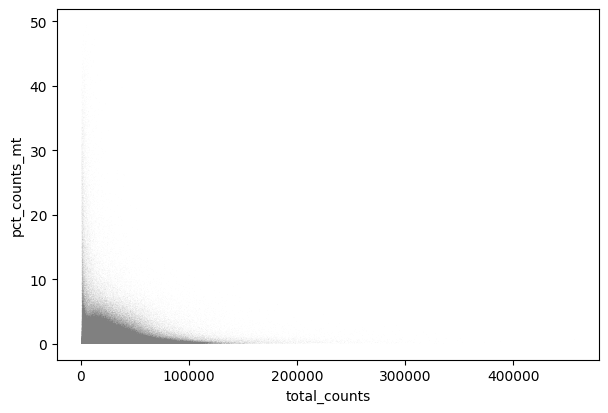

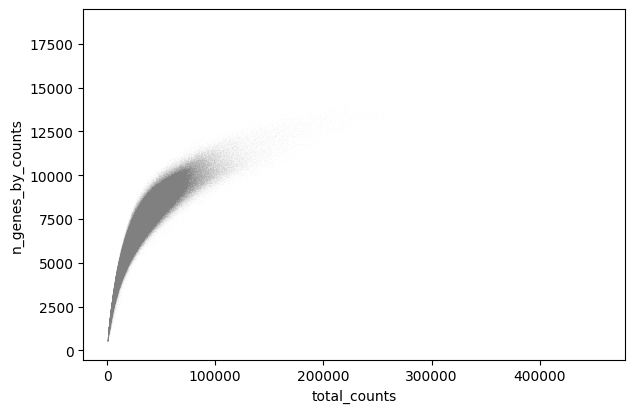

In [7]:
sc.pl.scatter(neurons, x = 'total_counts', y = 'pct_counts_mt')
sc.pl.scatter(neurons, x = 'total_counts', y = 'n_genes_by_counts')

Remove cells that have too many mitochondrial genes expressed or too many total counts. By inspection of the above plots, we choose a threshold of 15% mitochondrial genes and 7,000 total counts.

In [8]:
# number of cells before filtering
pre_filtered_cells = neurons.n_obs

# thresholds determined by inspection
neurons = neurons[neurons.obs.n_genes_by_counts < 12000, :]
neurons = neurons[neurons.obs.pct_counts_mt < 5, :]

# number of cells after filtering
post_filtered_cells = neurons.n_obs
print('Number of cells removed: {:d}'.format(pre_filtered_cells - post_filtered_cells))

neurons

Number of cells removed: 40627


View of AnnData object with n_obs × n_vars = 2387555 × 59480
    obs: 'BadCells', 'Paris10', 'Paris21', 'Paris9', 'PunchcardClusters', 'ROIGroup', 'ROIGroupCoarse', 'ROIGroupFine', 'Split', 'TopSplit', 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'cluster_id', 'subcluster_id', 'supercluster_term', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 

Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell, so that counts become comparable among cells. Next, apply a logarithmic transformation.

In [12]:
# total count normalize the data
sc.pp.normalize_total(neurons, target_sum = 1e4)

# apply log transformation
sc.pp.log1p(neurons)

# save normalized and log transformed data
neurons.write(output_dir / 'neurons_normalized_log.h5ad')

/n/data1/hms/dbmi/zitnik/lab/users/an252/NeuroKG/neuroKG/neuroKG_env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


# Add Annotations

Merge gene-level metadata with other annotations.

In [13]:
# read protein coding genes and fix names
mart = pd.read_csv(ensembl_dir / 'mart_export.txt')
new_mart_names = [x.lower() for x in mart.columns.values]
new_mart_names = [re.sub('\\s\\([^)]+\\)', '', x) for x in new_mart_names]
new_mart_names = [re.sub('\\s+', '_', x) for x in new_mart_names]
mart.columns = new_mart_names

# print dimension of annotation
print("Original dimension: {}".format(mart.shape))

# remove specified columns
columns_to_remove = ['gene_synonym', 'transcript_stable_id', 'protein_stable_id', 'gene_stable_id_version', 'protein_stable_id_version', 'transcript_stable_id_version']
mart = mart.drop(columns_to_remove, axis=1)

# remove duplicate rows
mart = mart.drop_duplicates(['gene_stable_id']).reset_index(drop = True)

# print dimension of annotation
print("Removing duplicate Ensembl IDs: {}".format(mart.shape))

# filter out rows with missing ncbi_gene_id
mart = mart.dropna(subset=['ncbi_gene_id'])
mart['ncbi_gene_id'] = mart['ncbi_gene_id'].astype(int)

# print dimension of annotation
print("Removing missing NCBI gene IDs: {}".format(mart.shape))

# show head
mart.head()

Original dimension: (635615, 14)
Removing duplicate Ensembl IDs: (69299, 8)
Removing missing NCBI gene IDs: (29921, 8)


,gene_stable_id,gene_type,gene_description,gene_start,gene_end,gene_name,ncbi_gene_description,ncbi_gene_id
5,ENSG00000198888,protein_coding,mitochondrially encoded NADH:ubiquinone oxidor...,3307,4262,MT-ND1,NADH dehydrogenase subunit 1,4535
9,ENSG00000198763,protein_coding,mitochondrially encoded NADH:ubiquinone oxidor...,4470,5511,MT-ND2,NADH dehydrogenase subunit 2,4536
15,ENSG00000198804,protein_coding,mitochondrially encoded cytochrome c oxidase I...,5904,7445,MT-CO1,cytochrome c oxidase subunit I,4512
16,ENSG00000210151,Mt_tRNA,mitochondrially encoded tRNA-Ser (UCN) 1 [Sour...,7446,7514,MT-TS1,microRNA 12136,113219467
18,ENSG00000198712,protein_coding,mitochondrially encoded cytochrome c oxidase I...,7586,8269,MT-CO2,cytochrome c oxidase subunit II,4513


Merge with the gene-level metadata.

In [14]:
# clean names of neurons by removing version
neurons.var.index = [re.sub('\\.[0-9]+', '', x) for x in neurons.var.index]

# check how many genes are in the nervous system data
neurons_genes = set(neurons.var_names)
print('Number of genes in Linnarsson et al.:', len(neurons_genes))

# check how many genes are in the mart data
mart_genes = set(mart['gene_stable_id'])
print('Number of genes in annotation:', len(mart_genes))

# check how many genes are in both
int_genes = mart_genes.intersection(neurons_genes)
print('Number of genes in both:', len(int_genes))

# get genes in snRNA-seq data but not in mart
not_in_mart = neurons_genes.difference(mart_genes)
print('Number of genes in snRNA-seq data but not in annotation:', len(not_in_mart))

Number of genes in Linnarsson et al.: 59480
Number of genes in annotation: 29921
Number of genes in both: 25797
Number of genes in snRNA-seq data but not in annotation: 33683


Merge with the gene-level metadata.

In [15]:
# merge gene annotations with snRNA-seq data
merged_var = neurons.var.merge(mart, how='left', left_index=True, right_on='gene_stable_id')

# print dimension of annotation
print("Original dimension: {}".format(neurons.var.shape))
print("Merging annotations with snRNA-seq data: {}".format(merged_var.shape))

# assert that index is equal to gene_stable_id
assert np.all(neurons.var.index == merged_var['gene_stable_id'])

# set index to gene_stable_id
merged_var = merged_var.set_index('gene_stable_id')

# rename gene symbol column as by convention
merged_var = merged_var.rename(columns={'gene_name': 'gene_symbols'})

# set metadata as merged_var
neurons.var = merged_var

# show head
merged_var.head()

Original dimension: (59480, 12)
Merging annotations with snRNA-seq data: (59480, 20)


,Biotype,Chromosome,End,Gene,Start,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,gene_type,gene_description,gene_start,gene_end,gene_symbols,ncbi_gene_description,ncbi_gene_id
gene_stable_id,,,,,,,,,,,,,,,,,,,
Cas9,protein_coding,chrEXTRA,12412,transgen-Cas9,8081,False,0,0.000000,0.000000,100.000000,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EGFP,protein_coding,chrEXTRA,13152,marker-EGFP,12433,False,0,0.000000,0.000000,100.000000,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000000003,n/a,chrX,100639991,TSPAN6,100627108,False,58195,0.026641,0.026292,97.603351,64688,11.077346,protein_coding,tetraspanin 6 [Source:HGNC Symbol;Acc:HGNC:11858],100627108.0,100639991.0,TSPAN6,tetraspanin 6,7105.0
ENSG00000000005,n/a,chrX,100599885,TNMD,100584936,False,6177,0.002951,0.002947,99.745612,7166,8.877242,protein_coding,tenomodulin [Source:HGNC Symbol;Acc:HGNC:17757],100584936.0,100599885.0,TNMD,tenomodulin,64102.0
ENSG00000000419,n/a,chr20,50958555,DPM1,50934867,False,1215419,0.928637,0.656814,49.945309,2254900,14.628617,protein_coding,dolichyl-phosphate mannosyltransferase subunit...,50934867.0,50959140.0,DPM1,dolichyl-phosphate mannosyltransferase subunit...,8813.0


Drop genes from the snRNA-seq data that don't have valid NCBI gene IDs.

In [16]:
# number of genes before filtering
pre_filtered_genes = neurons.n_vars
print('Number of genes before filtering: {:d}'.format(pre_filtered_genes))

# drop rows with missing ncbi_gene_id
neurons = neurons[:, ~neurons.var['ncbi_gene_id'].isnull()]
post_ncbi_genes = neurons.n_vars
print('Removing missing NCBI gene IDs: {:d}'.format(pre_filtered_genes - post_ncbi_genes))

# drop rows with missing gene_symbols
neurons = neurons[:, ~neurons.var['gene_symbols'].isnull()]
post_symbols_genes = neurons.n_vars
print('Removing missing gene symbols: {:d}'.format(post_ncbi_genes - post_symbols_genes))

# removing duplicated gene_symbols
neurons = neurons[:, ~neurons.var['gene_symbols'].duplicated()]
post_dup_symbols_genes = neurons.n_vars
print('Removing duplicated gene symbols: {:d}'.format(post_symbols_genes - post_dup_symbols_genes))

# print total genes remaining
print('Number of genes after filtering: {:d}'.format(post_symbols_genes))

# print neurons
neurons

Number of genes before filtering: 59480
Removing missing NCBI gene IDs: 33683
Removing missing gene symbols: 1158
Removing duplicated gene symbols: 138
Number of genes after filtering: 24639


View of AnnData object with n_obs × n_vars = 2387555 × 24501
    obs: 'BadCells', 'Paris10', 'Paris21', 'Paris9', 'PunchcardClusters', 'ROIGroup', 'ROIGroupCoarse', 'ROIGroupFine', 'Split', 'TopSplit', 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'cluster_id', 'subcluster_id', 'supercluster_term', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_ty

Set index as gene symbols.

In [17]:
# make copy of neurons into memory
neurons = neurons.copy()

# add column for Ensembl
neurons.var['gene_stable_id'] = neurons.var.index

# make gene symbols the new index
neurons.var = neurons.var.set_index('gene_symbols')

# Highly Variable Genes

Identify highly variable genes.

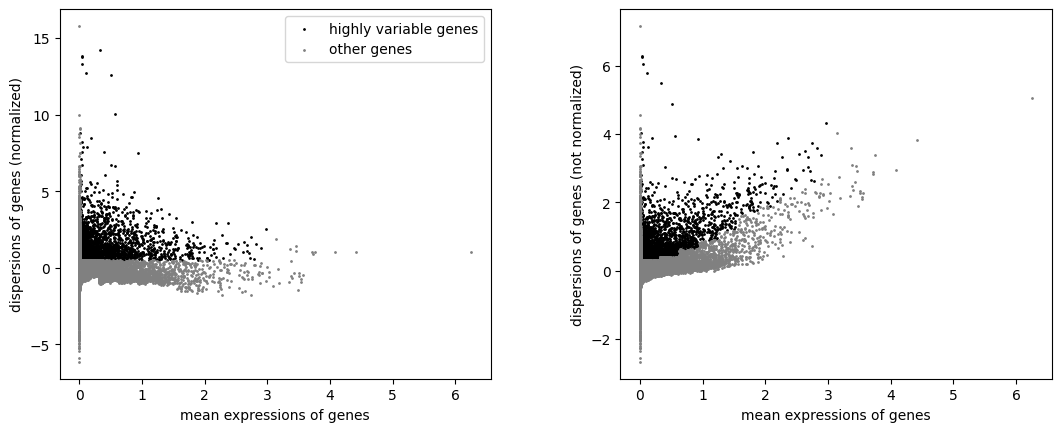

In [18]:
# identify highly variable genes
sc.pp.highly_variable_genes(neurons, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)

# plot highly variable genes
sc.pl.highly_variable_genes(neurons)

Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object. Next, filter for highly variable genes.

See [this issue](https://github.com/scverse/scanpy/issues/967) for a discussion on what should be stored in the `.raw` attribute.

In [19]:
# freeze state
neurons.raw = neurons

# filter for highly variable genes
# neurons = neurons[:, neurons.var.highly_variable]

# print object
neurons

AnnData object with n_obs × n_vars = 2387555 × 24501
    obs: 'BadCells', 'Paris10', 'Paris21', 'Paris9', 'PunchcardClusters', 'ROIGroup', 'ROIGroupCoarse', 'ROIGroupFine', 'Split', 'TopSplit', 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'cluster_id', 'subcluster_id', 'supercluster_term', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_type', 'ge

In [4]:
# save object
# neurons.write(output_dir / 'neurons_normalized_log_filtered.h5ad')

# read object
neurons = sc.read_h5ad(output_dir / 'neurons_normalized_log_filtered.h5ad')

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed.

In [ ]:
# regress out total counts per cell and the percentage of mitochondrial genes expressed
# sc.pp.regress_out(neurons, ['total_counts', 'pct_counts_mt'])

Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [5]:
# scale to unit variance
sc.pp.scale(neurons, max_value = 10)

# save object
neurons.write(output_dir / 'neurons_normalized_log_scaled.h5ad')

# print object
neurons

AnnData object with n_obs × n_vars = 2387555 × 24501
    obs: 'BadCells', 'Paris10', 'Paris21', 'Paris9', 'PunchcardClusters', 'ROIGroup', 'ROIGroupCoarse', 'ROIGroupFine', 'Split', 'TopSplit', 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'cluster_id', 'subcluster_id', 'supercluster_term', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_type', 'ge

Read object if needed.

In [3]:
# if needed, read back object
# neurons = sc.read_h5ad(output_dir / 'neurons_normalized_log_scaled.h5ad')
neurons

# Clusters and Subclusters

In [55]:
# select columns from neurons.obs
# with cluster_id and subcluster_id only, 297 rows
# with supercluster_term, still 297 rows
# with ROIGroupCoarse, 2185 rows
# with ROIGroupFine, 2827 rows
cluster_list = neurons.obs[['supercluster_term', 'cluster_id', 'subcluster_id']]

# node_columns = ['ROIGroupCoarse', 'ROIGroupFine', 'supercluster_term', 'cluster_id', 'subcluster_id', 'CELLxGENE_ontology_term_id', 'tissue_ontology_term_id']
# cluster_data = neurons.obs[node_columns]

# drop duplicates and order by cluster_id, subcluster_id
cluster_list = cluster_list.drop_duplicates()
cluster_list = cluster_list.sort_values(by = ['cluster_id', 'subcluster_id'], ascending = True).reset_index(drop = True)
cluster_list

,supercluster_term,cluster_id,subcluster_id
0,Miscellaneous,0,3293
1,Miscellaneous,1,3298
2,Miscellaneous,1,3299
3,Miscellaneous,1,3300
4,Miscellaneous,1,3301
...,...,...,...
2942,Thalamic excitatory,460,41
2943,Thalamic excitatory,460,42
2944,Thalamic excitatory,460,43
2945,Thalamic excitatory,460,55


Next, get lists of cluster IDs and subcluster IDs. Find markers for all clusters and subclusters.

In [5]:
# get supercluster terms
supercluster_terms = cluster_list['supercluster_term'].unique()

# get cluster IDs
cluster_ids = cluster_list['cluster_id'].unique()

# get subcluster IDs
subcluster_ids = cluster_list['subcluster_id'].unique()

# print number of clusters, subclusters, and superclusters
print('Number of superclusters:', len(supercluster_terms))
print('Number of clusters:', len(cluster_ids))
print('Number of subclusters:', len(subcluster_ids))

Number of superclusters: 21
Number of clusters: 371
Number of subclusters: 2947


# Dimensionality Reduction Visualization

Rename the UMAP and t-SNE names in the [`.obsm` property](https://anndata.readthedocs.io/en/latest/generated/anndata.AnnData.obsm.html).

In [6]:
print("Previous names: ", neurons.obsm_keys())

# rename 'X_UMAP' to 'x_umap'
neurons.obsm['umap'] = neurons.obsm['X_UMAP']
del neurons.obsm['X_UMAP']

# rename 'X_UMAP' to 'x_umap'
neurons.obsm['tsne'] = neurons.obsm['X_tSNE']
del neurons.obsm['X_tSNE']

print("Updated names: ", neurons.obsm_keys())

Previous names:  ['X_UMAP', 'X_tSNE']
Updated names:  ['umap', 'tsne']


Plot cell type markers from Figure 1.

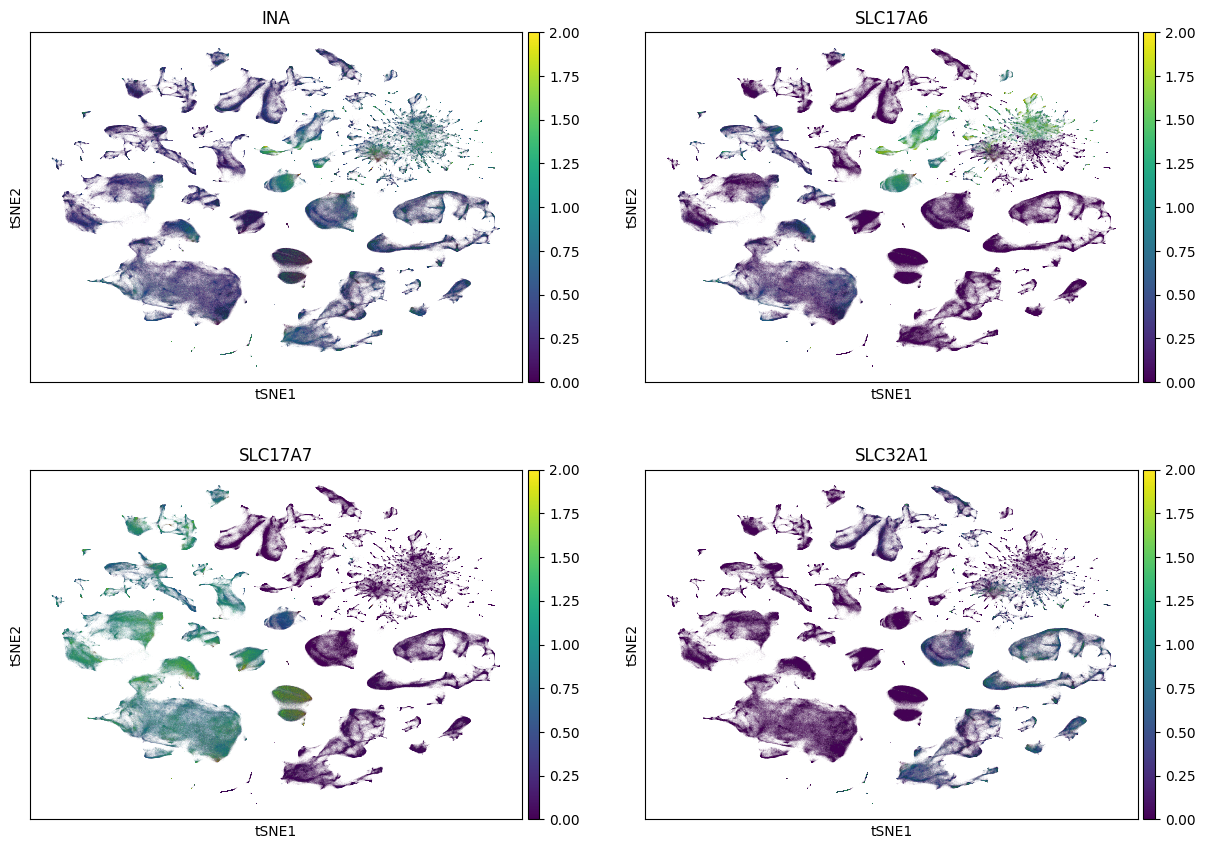

In [9]:
# get index values for gene symbols
neuron_markers = ['INA', 'SLC17A6', 'SLC17A7', 'SLC32A1']
genes_to_plot = neuron_markers # neurons.var[neurons.var['gene_symbols'].isin(neuron_markers)].index.values

# create t-SNE plot
fig = sc.pl.tsne(neurons, color = genes_to_plot, #.index.values, title = genes_to_plot.gene_symbols, 
                 vmax = 2, ncols = 2, use_raw = True, return_fig = True)

# save figure
fig.savefig(project_config.PROJECT_DIR / 'Results' / 'CELLxGENE' / 'neuron_markers.png', dpi = 300, bbox_inches = 'tight')

# Marker Gene Identification

We use [`scanpy.tl.rank_genes_groups`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.rank_genes_groups.html) to identify marker genes for each supercluster, cluster, and subcluster. We use the `t-test` method to compute the ranking. See [this discussion](https://github.com/scverse/scanpy/issues/2029) for information about using raw vs. scaled data.

In [7]:
# compute total number of cells in each supercluster
neurons.obs.supercluster_term.value_counts()

Upper-layer intratelencephalic       452715
Splatter                             273703
CGE interneuron                      226007
MGE interneuron                      219640
Deep-layer intratelencephalic        209135
Medium spiny neuron                  150318
Upper rhombic lip                    136377
Midbrain-derived inhibitory          124243
Amygdala excitatory                  106706
Deep-layer corticothalamic and 6b     77365
Thalamic excitatory                   75529
Hippocampal dentate gyrus             67245
Hippocampal CA1-3                     52990
Lower rhombic lip                     49523
LAMP5-LHX6 and Chandelier             44519
Eccentric medium spiny neuron         39628
Miscellaneous                         24422
Deep-layer near-projecting            18736
Mammillary body                       14205
Cerebellar inhibitory                 13974
Hippocampal CA4                       10575
Name: supercluster_term, dtype: int64

For `neurons.uns['log1p']["base"] = None`, see:
* [Pull #2546](https://github.com/scverse/scanpy/pull/2546)
* [Issue #2181](https://github.com/scverse/scanpy/issues/2181)
* [Issue #2239](https://github.com/scverse/scanpy/issues/2239)

In [ ]:
# see GitHub issues linked above
neurons.uns['log1p']["base"] = None

Find supercluster marker genes.

In [8]:
# check for NA values in data matrix
# np.any(np.isnan(neurons.X))

# find supercluster marker genes
sc.tl.rank_genes_groups(neurons, 'supercluster_term', method = 't-test', key_added = 'supercluster_markers', use_raw = True)

Visualize supercluster marker genes.

In [ ]:
# visualize supercluster marker genes
sc.pl.rank_genes_groups(neurons, n_genes = 25, key = 'supercluster_markers', sharey = False)

Print top 20 supercluster marker genes.

In [ ]:
pd.DataFrame(neurons.uns['supercluster_markers']['names']).head(20)

Create a DataFrame with the marker genes for each supercluster; then, save to file.

In [ ]:
# create table
supercluster_result = neurons.uns['supercluster_markers']
groups = supercluster_result['names'].dtype.names
supercluster_markers = pd.DataFrame(
    {group + '_' + key: supercluster_result[key][group]
     for group in groups for key in ['names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges']})

# save supercluster markers
supercluster_markers.to_csv(output_dir / 'neuron_markers' / 'supercluster_markers.csv', index = False)

# show head
supercluster_markers.head()

Iterate over superclusters to get cluster marker genes within each supercluster.

In [ ]:
# iterate over superclusters
for supercluster in supercluster_terms:

    # set key name
    key_name = supercluster + '_markers'

    # get cluster IDs
    supercluster_members = cluster_list[cluster_list['supercluster_term'] == supercluster]['cluster_id'].unique().tolist()

    # print number of clusters
    print('Clusters in {}: {}'.format(supercluster, len(supercluster_members)))

    if(len(supercluster_members) > 1):

        # filter for supercluster members
        # instead of using groups = supercluster_members (which would look for markers across all supercluster members)
        supercluster_data = neurons[neurons.obs['cluster_id'].isin(supercluster_members), :].copy()

        # print number of cells
        print('Cells in {}: {}'.format(supercluster, supercluster_data.n_obs))

        # assign number of cells to cluster_list
        cluster_list.loc[cluster_list['supercluster_term'] == supercluster, 'supercluster_n_cells'] = supercluster_data.n_obs

        # find cluster marker genes
        sc.tl.rank_genes_groups(supercluster_data, 'cluster_id', method = 't-test', key_added = key_name, use_raw = True)

        # get cluster marker results
        cluster_result = supercluster_data.uns[key_name] # instead of neurons.uns['cluster_markers']
        groups = cluster_result['names'].dtype.names
        cluster_markers = pd.DataFrame(
        {group + '_' + key: cluster_result[key][group]
        for group in groups for key in ['names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges']})

        # save cluster markers
        cluster_markers.to_csv(output_dir / 'neuron_markers' / (supercluster + '_markers.csv'), index = False)

    else:

        # print error message
        print('Skipping {} because it has only one cluster.'.format(supercluster))

Identify marker genes for the subclusters and save to file. Print log messages every 10 clusters.

In [ ]:
# iterate over superclusters
for cluster_index, cluster in enumerate(cluster_ids):

    # set key name
    key_name = 'cluster_' + str(cluster) + '_markers'

    # get cluster IDs
    cluster_members = cluster_list[cluster_list['cluster_id'] == cluster]['subcluster_id'].unique()

    # print number of clusters
    # print('Subclusters in cluster {}: {}'.format(cluster, len(cluster_members)))

    # check cell counts, see if any clusters have < 2 cells; if so, skip
    cluster_data_view = neurons[neurons.obs['subcluster_id'].isin(cluster_members), :]
    too_small_clusters = cluster_data_view.obs['subcluster_id'].value_counts().loc[lambda x: x < 2].index.values

    # drop cluster members with index in check_cell_counts (i.e., < 2 cells)
    cluster_members = cluster_members[cluster_members.isin(too_small_clusters) == False].tolist()

    if(len(cluster_members) > 1):

        # filter for cluster members
        cluster_data = neurons[neurons.obs['subcluster_id'].isin(cluster_members), :].copy()

        # print number of cells
        # print('Cells in cluster {}: {}'.format(cluster, cluster_data.n_obs))

        # assign number of cells to cluster_list
        cluster_list.loc[cluster_list['cluster_id'] == cluster, 'cluster_n_cells'] = cluster_data.n_obs

        # iterate over subclusters
        for subcluster in cluster_members:

            # assign number of cells to cluster_list
            cluster_list.loc[cluster_list['subcluster_id'] == subcluster, 'subcluster_n_cells'] = cluster_data[cluster_data.obs['subcluster_id'] == subcluster, :].n_obs

        # print cluster index to file in same line
        print('Cluster {} of {}: {} cells'.format(cluster_index + 1, len(cluster_ids), cluster_data.n_obs), end = '\r')

        # find cluster marker genes
        sc.tl.rank_genes_groups(cluster_data, 'subcluster_id', method = 't-test', key_added = key_name, use_raw = True)

        # get cluster marker results
        subcluster_result = cluster_data.uns[key_name] # instead of neurons.uns['cluster_markers']
        groups = subcluster_result['names'].dtype.names
        subcluster_markers = pd.DataFrame(
        {group + '_' + key: subcluster_result[key][group]
        for group in groups for key in ['names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges']})

        # save cluster markers
        subcluster_markers.to_csv(output_dir / 'neuron_markers' / ('cluster_' + str(cluster) + '_markers.csv'), index = False)

    else:

        # print error message
        # print('Skipping {} because it has only one subcluster.'.format(supercluster))
        pass

# Save Data

Save the AnnData object to an `.h5ad` file.

In [64]:
# save cluster list
cluster_list.to_csv(output_dir / 'neuron_markers' / 'cluster_list.csv', index = False)

# save AnnData object
neurons.write_h5ad(output_dir /  'neurons_processed.h5ad')

If needed, read back the object. Remember to run the first two cells to load libraries and set paths.

In [3]:
# read back AnnData object
neurons = sc.read_h5ad(output_dir / 'neurons_processed.h5ad')

Write gene-level (*i.e.*, `var`) and cell-level (*i.e.*, `obs`) metadata to file for downstream analysis during cell type construction.

In [4]:
# write gene metadata to file
neurons.var.to_csv(output_dir / 'neurons_var_gene_metadata.csv', index = True)

# write cell metadata to file
neurons.obs.to_csv(output_dir / 'neurons_obs_cell_metadata.csv', index = True)